In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import gc # garbage collections
import bz2 # to open zipped files

# Loading the dataset

In [2]:
train = bz2.BZ2File('../input/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('../input/amazonreviews/test.ft.txt.bz2')

In [3]:
train = train.readlines()
test = test.readlines()

train[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [4]:
# convert from raw binary strings into text files that can be parsed

train = [x.decode('utf-8') for x in train]
test = [x.decode('utf-8') for x in test]

In [5]:
train[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [6]:
print(type(train), type(test), "\n")

print(f"Train Data Volume: {len(train)}\n")
print(f"Test Data Volume: {len(test)}\n\n")

print("Demo: ", "\n")
for x in train[:5]:
    print(x, "\n")

<class 'list'> <class 'list'> 

Train Data Volume: 3600000

Test Data Volume: 400000


Demo:  

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
 

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, thi

In [7]:
# extract labels from the dataset
# judging from the dataset, let's set 0 for negative sentiment and 1 for positive sentiment

train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train] 
test_labels = [0 if x.split(' ')[0] =='__label__1' else 1 for x in test]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train Labels Distribution')

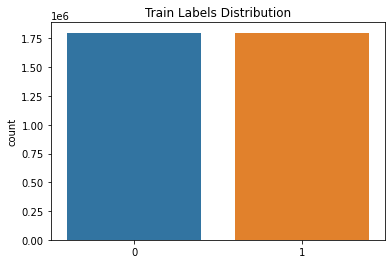

In [8]:
sns.countplot(train_labels)
plt.title('Train Labels Distribution')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Labels Distribution')

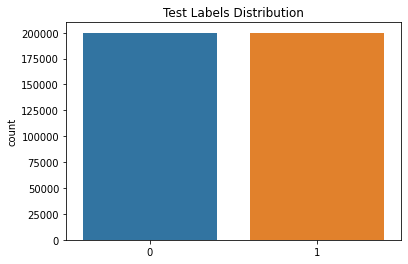

In [9]:
sns.countplot(test_labels)
plt.title('Test Labels Distribution')

In [10]:
# let's extract the texts

train_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in train]
test_texts = [x.split(' ', maxsplit=1)[1][:-1] for x in test]

train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [11]:
del train, test

gc.collect()

70

## Exploratory Data Analysis

### Word Cloud

In [12]:
from wordcloud import WordCloud

In [13]:
# let's have a corpus for all the texts in train_text

corpus = ' '.join(text for text in train_texts[:100000])
print(f'There are {len(corpus)} words in the corpus')

There are 44053838 words in the corpus


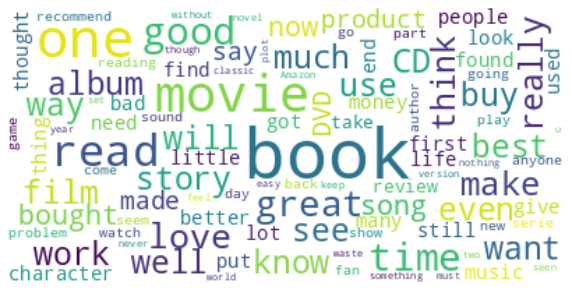

In [14]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white')
wordcloud = wordcloud.generate(corpus)


plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [15]:
del wordcloud

gc.collect()

3192

### Distribution of word count

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

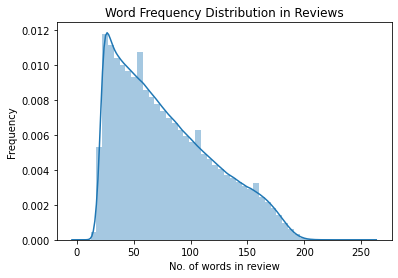

In [16]:
# let's count the number of words in the review and see the distribution

train_texts_size = list(map(lambda x: len(x.split()), train_texts))
sns.distplot(train_texts_size)
plt.xlabel('No. of words in review')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in Reviews')

In [17]:
train_size_df = pd.DataFrame({'len': train_texts_size, 'labels': train_labels})
train_size_df.head(10)

,len,labels
0,80,1
1,97,1
2,129,1
3,118,1
4,87,1
5,142,1
6,139,0
7,105,1
8,103,1
9,63,1


Negative mean length: 81.50
Positive mean length:  75.46
Mean difference: 6.04


Text(0.5, 6.79999999999999, 'Label -> 0 for Negative and 1 for Positive')

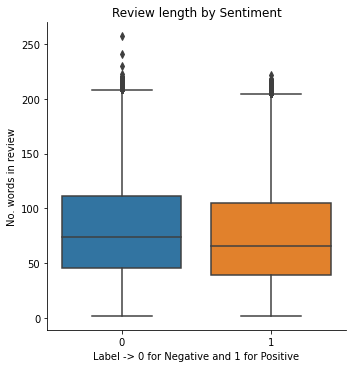

In [18]:
neg_mean_len = train_size_df[train_size_df['labels'] == 0]['len'].mean()
pos_mean_len = train_size_df[train_size_df['labels'] == 1]['len'].mean()

print(f'Negative mean length: {neg_mean_len:.2f}')
print(f'Positive mean length: {pos_mean_len: .2f}')
print(f'Mean difference: {neg_mean_len - pos_mean_len:.2f}')

sns.catplot(x='labels', y='len', data=train_size_df, kind='box')
plt.title('Review length by Sentiment')
plt.ylabel('No. words in review')
plt.xlabel('Label -> 0 for Negative and 1 for Positive')

In [19]:
del train_size_df

gc.collect()

24

## Tokenizing and Vectorizing

In [20]:
len(train_texts), len(test_texts)

(3600000, 400000)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 70000 # number of words from the train_text to tokenize by frequency
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_texts)

# let's see the dictionary of words tokenized

word_index = tokenizer.word_index
print(f'The size of the vocabulary: {len(word_index)}')
word_index

The size of the vocabulary: 1103003


{'the': 1,
 'and': 2,
 'i': 3,
 'a': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'this': 8,
 'is': 9,
 'in': 10,
 'for': 11,
 'that': 12,
 'was': 13,
 'not': 14,
 'you': 15,
 'but': 16,
 'with': 17,
 'on': 18,
 'book': 19,
 'have': 20,
 'my': 21,
 'as': 22,
 'are': 23,
 'one': 24,
 'be': 25,
 'so': 26,
 'all': 27,
 'if': 28,
 'great': 29,
 'very': 30,
 'good': 31,
 'like': 32,
 'they': 33,
 'at': 34,
 'just': 35,
 'from': 36,
 'or': 37,
 'would': 38,
 'out': 39,
 'about': 40,
 'an': 41,
 'me': 42,
 'has': 43,
 'what': 44,
 'more': 45,
 'had': 46,
 'will': 47,
 'read': 48,
 'when': 49,
 "it's": 50,
 'get': 51,
 'no': 52,
 'up': 53,
 'by': 54,
 'time': 55,
 'there': 56,
 'only': 57,
 'your': 58,
 'can': 59,
 'movie': 60,
 'he': 61,
 'his': 62,
 "don't": 63,
 'really': 64,
 'some': 65,
 'do': 66,
 'well': 67,
 'than': 68,
 'them': 69,
 'who': 70,
 'much': 71,
 'even': 72,
 'first': 73,
 'other': 74,
 'we': 75,
 'these': 76,
 'her': 77,
 'after': 78,
 'love': 79,
 'because': 80,
 'buy': 81,
 'too': 

In [22]:
# let's save the tokenizer for future use

import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
   # tokenizer = pickle.load(handle)

In [23]:
sequences = tokenizer.texts_to_sequences(train_texts)
print(len(sequences))

# pad sequences to the same shape
maxlen = 100
sequences = pad_sequences(sequences, maxlen=maxlen)

3600000


In [24]:
sequences[0].shape

(100,)

In [25]:
train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [26]:
len(train_labels)

3600000

In [27]:
# let's convert to numpy array
import numpy as np

labels = np.array(train_labels)

In [28]:
# let's reduce the dataset size...
# train_texts should be 400,000 and test_text should be 20,000

# first we shuffle numbers from & 400000

indices = np.arange(len(train_texts))
np.random.shuffle(indices)
train_data = sequences[indices]
train_labels = labels[indices]

In [29]:
train_size = 400000
train_data = train_data[:train_size]
train_labels = train_labels[:train_size]

In [30]:
# let's split the dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, random_state=42, test_size=0.2)

In [31]:
len(X_train), len(X_valid)

(320000, 80000)

In [32]:
X_train.shape

(320000, 100)

In [33]:
# sanity check

sanity_text = tokenizer.sequences_to_texts(sequences[:3])
sanity_text

['even for the non gamer this sound track was beautiful it paints the in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen',
 "the best soundtrack ever to anything i'm reading a lot of reviews saying that this is the best and i figured that i'd write a review to disagree a bit this in my is ultimate masterpiece the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny",
 "the game and the hope in a distant promise and girl who stole the star have been an important inspiration to me personally througho

In [34]:
train_texts[:3]

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'Amazing!: This soundtrack is my favorite music of all

In [35]:
sanity_text = tokenizer.sequences_to_texts(X_train[:3])
sanity_text

['to syndicate i own a number of consoles and a pc and of course the genesis is one of them i enjoy playing outdated games super smash tv outlander predator 2 among others and syndicate is one of them it is a classic sure all too many people will gripe about slowdown memory etc but this is by far one of the most original games ever you play as a terrorist faction attempting to overtake a large corporation with an equally large on several intresting missions could have used a 2 player mode but otherwise this is a solid title',
 'soul searching soulfull blues this cd is one of the best releases that i have heard in a couple of years',
 'bollywood in also works its a great movie with beautiful sound effects i that ar has done beautiful job by bringing out out of mumbai its a story about common man thinking to become a movie star its fun watch it guyz']

All works and we can see most of the texts from each review is kept

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Labels Distribution')

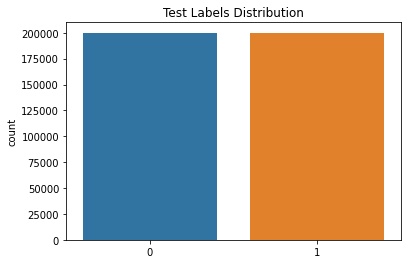

In [36]:
sns.countplot(train_labels)
plt.title('Test Labels Distribution')

In [37]:
del sequences, train_texts, train_data

gc.collect()

24

### Preprocessing the Test set

In [38]:
len(test_texts)

400000

In [39]:
# convert test_labels to numpy arrays
test_labels = np.array(test_labels)

# vectorize the test set
test = tokenizer.texts_to_sequences(test_texts)

# pad the sequence 
test = pad_sequences(test, maxlen=maxlen)

In [40]:
# let's reduce the dataset size
indices = np.arange(len(test_texts))
np.random.shuffle(indices)
test = test[indices]
test_labels = test_labels[indices]

test_size = 40000
test = test[:test_size]
test_labels = test_labels[:test_size]

In [41]:
# sanity check

print(test_texts[:3])
print('\n')
print(tokenizer.sequences_to_texts(test[:3]))

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of so

# ML Models

## Baseline Model

In [42]:
embedding_dim = 100

In [43]:
model = models.Sequential(name='baseline_amazon')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 7, padding='valid', activation='relu'))
model.add(layers.Conv1D(128, 7, padding='valid', activation='relu'))
model.add(layers.Conv1D(256, 7, padding='valid', activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-03-21 23:50:34.601179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:50:34.691477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:50:34.692172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:50:34.693418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [44]:
model.summary()

Model: "baseline_amazon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          7000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 64)            44864     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 128)           57472     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 82, 256)           229632    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)           

In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
             keras.callbacks.ModelCheckpoint('baseline.h5', save_best_only=True)]

In [46]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=callbacks)

2022-03-21 23:50:52.233783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-21 23:50:53.955540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10000/10000 [==============================] - 69s 6ms/step - loss: 0.2535 - accuracy: 0.8947 - val_loss: 0.2054 - val_accuracy: 0.9186
Epoch 2/20
10000/10000 [==============================] - 63s 6ms/step - loss: 0.1668 - accuracy: 0.9373 - val_loss: 0.2104 - val_accuracy: 0.9208
Epoch 3/20
10000/10000 [==============================] - 63s 6ms/step - loss: 0.1125 - accuracy: 0.9601 - val_loss: 0.2366 - val_accuracy: 0.9163
Epoch 4/20
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0704 - accuracy: 0.9765 - val_loss: 0.2538 - val_accuracy: 0.9119
Epoch 5/20
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0450 - accuracy: 0.9854 - val_loss: 0.3695 - val_accuracy: 0.9074
Epoch 6/20
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 0.3756 - val_accuracy: 0.9067
Epoch 7/20
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.4804 - val

In [47]:
def learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, 'bo', label='Train Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

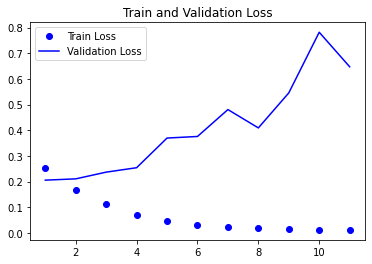

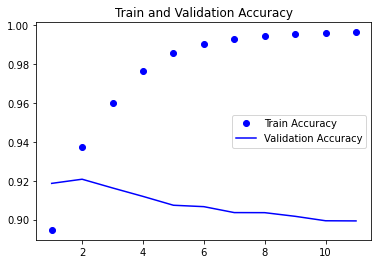

In [48]:
learning_curve(history)

In [49]:
# let's evaluate the model's result on the test set

loss_1, acc_1 = model.evaluate(test, test_labels)
loss_1, acc_1

1250/1250 [==============================] - 3s 2ms/step - loss: 0.2100 - accuracy: 0.9166


(0.21000580489635468, 0.9166250228881836)

## Baseline Model + BatchNorm & Higher Dropout

In [50]:
model = models.Sequential(name='baseline2_amazon')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, 7, padding='valid', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 7, padding='valid', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [51]:
model.summary()

Model: "baseline2_amazon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100)          400       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 64)            44800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 94, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 88, 128)           57344     
_________________________________________________________________
batch_normalization_2 (Batch (None, 88, 128)      

In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
             keras.callbacks.ModelCheckpoint('baseline2.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/10
10000/10000 [==============================] - 63s 6ms/step - loss: 0.2818 - accuracy: 0.8805 - val_loss: 0.2191 - val_accuracy: 0.9140
Epoch 2/10
10000/10000 [==============================] - 62s 6ms/step - loss: 0.1939 - accuracy: 0.9255 - val_loss: 0.2009 - val_accuracy: 0.9211
Epoch 3/10
10000/10000 [==============================] - 63s 6ms/step - loss: 0.1396 - accuracy: 0.9490 - val_loss: 0.2099 - val_accuracy: 0.9176
Epoch 4/10
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0962 - accuracy: 0.9666 - val_loss: 0.2258 - val_accuracy: 0.9140
Epoch 5/10
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0691 - accuracy: 0.9767 - val_loss: 0.2635 - val_accuracy: 0.9079
Epoch 6/10
10000/10000 [==============================] - 62s 6ms/step - loss: 0.0518 - accuracy: 0.9826 - val_loss: 0.2688 - val_accuracy: 0.9056
Epoch 7/10
10000/10000 [==============================] - 63s 6ms/step - loss: 0.0419 - accuracy: 0.9862 - val_loss: 0

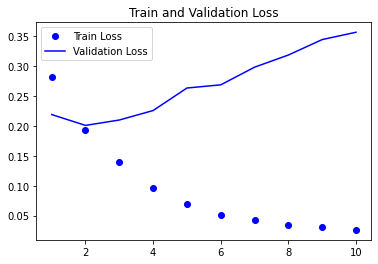

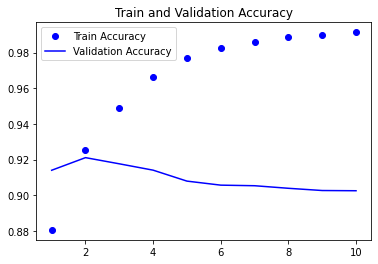

In [53]:
learning_curve(history)

In [54]:
loss_2, acc_2 = model.evaluate(test, test_labels)
loss_2, acc_2

1250/1250 [==============================] - 3s 2ms/step - loss: 0.3626 - accuracy: 0.9015


(0.36255812644958496, 0.9014999866485596)

### Model 3 - LSTM

In [55]:
model = models.Sequential(name='lstm_amazon')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [56]:
model.summary()

Model: "lstm_amazon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 7,042,305
Trainable params: 7,042,305
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint('lstm_amazon.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/10
10000/10000 [==============================] - 82s 8ms/step - loss: 0.2447 - accuracy: 0.9013 - val_loss: 0.1927 - val_accuracy: 0.9245
Epoch 2/10
10000/10000 [==============================] - 81s 8ms/step - loss: 0.1600 - accuracy: 0.9398 - val_loss: 0.1889 - val_accuracy: 0.9275
Epoch 3/10
10000/10000 [==============================] - 81s 8ms/step - loss: 0.1177 - accuracy: 0.9574 - val_loss: 0.2136 - val_accuracy: 0.9262
Epoch 4/10
10000/10000 [==============================] - 81s 8ms/step - loss: 0.0845 - accuracy: 0.9705 - val_loss: 0.2432 - val_accuracy: 0.9211
Epoch 5/10
10000/10000 [==============================] - 81s 8ms/step - loss: 0.0618 - accuracy: 0.9791 - val_loss: 0.2732 - val_accuracy: 0.9178
Epoch 6/10
10000/10000 [==============================] - 81s 8ms/step - loss: 0.0463 - accuracy: 0.9846 - val_loss: 0.3051 - val_accuracy: 0.9147
Epoch 7/10
10000/10000 [==============================] - 81s 8ms/step - loss: 0.0355 - accuracy: 0.9881 - val_loss: 0

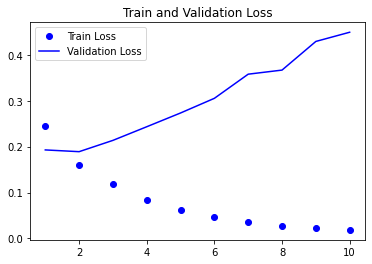

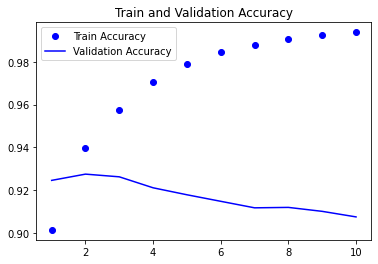

In [58]:
learning_curve(history)

In [59]:
loss_3, acc_3 = model.evaluate(test, test_labels)
loss_3, acc_3

1250/1250 [==============================] - 4s 3ms/step - loss: 0.4581 - accuracy: 0.9061


(0.4580770432949066, 0.9060999751091003)

### Bidirectional LSTM

In [60]:
model = models.Sequential(name='bidirectional_lstm')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, return_sequences=False)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [61]:
model.summary()

Model: "bidirectional_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 7,092,801
Trainable params: 7,092,801
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint('bilstm_amazon.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.2494 - accuracy: 0.8996 - val_loss: 0.1951 - val_accuracy: 0.9237
Epoch 2/20
10000/10000 [==============================] - 126s 13ms/step - loss: 0.1648 - accuracy: 0.9387 - val_loss: 0.1997 - val_accuracy: 0.9255
Epoch 3/20
10000/10000 [==============================] - 126s 13ms/step - loss: 0.1221 - accuracy: 0.9562 - val_loss: 0.2041 - val_accuracy: 0.9253
Epoch 4/20
10000/10000 [==============================] - 126s 13ms/step - loss: 0.0880 - accuracy: 0.9696 - val_loss: 0.2360 - val_accuracy: 0.9204
Epoch 5/20
10000/10000 [==============================] - 125s 13ms/step - loss: 0.0626 - accuracy: 0.9789 - val_loss: 0.2974 - val_accuracy: 0.9146
Epoch 6/20
10000/10000 [==============================] - 126s 13ms/step - loss: 0.0468 - accuracy: 0.9845 - val_loss: 0.3102 - val_accuracy: 0.9142
Epoch 7/20
10000/10000 [==============================] - 126s 13ms/step - loss: 0.0362 - accuracy: 0.9881

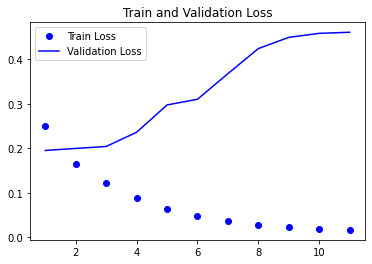

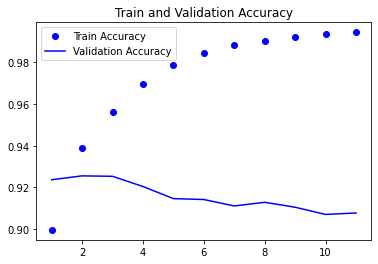

In [63]:
learning_curve(history)

In [64]:
loss_4, acc_4 = model.evaluate(test, test_labels)
loss_4, acc_4

1250/1250 [==============================] - 6s 4ms/step - loss: 0.4717 - accuracy: 0.9064


(0.4717457592487335, 0.906374990940094)

## Using Pretrained glove Embeddings

In [65]:
model = models.Sequential(name='pretrained_embeddings')
model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.LSTM(64, dropout=0.2, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [66]:
model.summary()

Model: "pretrained_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 7,042,305
Trainable params: 7,042,305
Non-trainable params: 0
_________________________________________________________________


In [68]:
# we need to use the glove embeddings to set the weights of the Embedding layer

embedding_path = '../input/glove6b100dtxt/glove.6B.100d.txt'

# create a dictionary to store the index
embedding_index = {}
f = open(embedding_path)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs

f.close()
print(f'There are {len(embedding_index)} words found')

There are 400000 words found


In [69]:
# initialize an zero matrix of shape (num_words, embedding_dim)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, index in word_index.items():
    if index < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector # maps each index in our word_index to its glove embeddings

In [73]:
embedding_matrix[0].shape

(100,)

In [74]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [75]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=15, restore_best_weights=False), 
             keras.callbacks.ModelCheckpoint('glove_amazon.h5', save_best_only=True)]

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/30
10000/10000 [==============================] - 61s 6ms/step - loss: 0.3495 - accuracy: 0.8445 - val_loss: 0.2812 - val_accuracy: 0.8810
Epoch 2/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2685 - accuracy: 0.8874 - val_loss: 0.2318 - val_accuracy: 0.9049
Epoch 3/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2442 - accuracy: 0.8988 - val_loss: 0.2198 - val_accuracy: 0.9105
Epoch 4/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2313 - accuracy: 0.9051 - val_loss: 0.2132 - val_accuracy: 0.9139
Epoch 5/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2227 - accuracy: 0.9094 - val_loss: 0.2073 - val_accuracy: 0.9167
Epoch 6/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2165 - accuracy: 0.9129 - val_loss: 0.2061 - val_accuracy: 0.9168
Epoch 7/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2109 - accuracy: 0.9147 - val_loss: 0

In [76]:
model.summary()

Model: "pretrained_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          7000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 7,042,305
Trainable params: 42,305
Non-trainable params: 7,000,000
_________________________________________________________________


In [77]:
loss_5, acc_5 = model.evaluate(test, test_labels)
loss_5, acc_5

1250/1250 [==============================] - 4s 3ms/step - loss: 0.2077 - accuracy: 0.9197


(0.20765915513038635, 0.9196500182151794)

In [79]:
result = pd.DataFrame({'loss': [loss_1, loss_2, loss_3, loss_4, loss_5], 
                      'accuracy': [acc_1, acc_2, acc_3, acc_4, acc_5], 
                      }, index = ['Baseline', 'Baseline with dropout', 'LSTM Model', 'Bidirectional LSTM',
                                 'Pretrained Embeddings'])
result

,loss,accuracy
Baseline,0.210006,0.916625
Baseline with dropout,0.362558,0.901500
LSTM Model,0.458077,0.906100
Bidirectional LSTM,0.471746,0.906375
Pretrained Embeddings,0.207659,0.919650
